In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from lib.ClassDatasetLoader import ClassDatasetLoader
from lib.ClassFCNN import ClassFCNN
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [16]:
device = 'cpu'

In [19]:
train_data = ClassDatasetLoader(r'..\data\processed_heart_disease.csv', count=0.8, begin="head")
test_data = ClassDatasetLoader(r'..\data\processed_heart_disease.csv', count=0.2, begin="tail")

train_data, val_data = random_split(train_data, [0.8, 0.2])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [20]:
fcnn = ClassFCNN(28, 5).to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(fcnn.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=7,
                                                          threshold=1e-4,
                                                          threshold_mode='rel',
                                                          cooldown=3,
                                                          min_lr=0,
                                                          eps=1e-8,
                                                          )

In [21]:
EPOCHS = 5
train_loss, train_acc, val_loss, val_acc = [], [], [], []
train_precision, train_recall, train_f1 = [], [], []
val_precision, val_recall, val_f1 = [], [], []
list_ = []

for epoch in range(EPOCHS):
    fcnn.train()
    running_train_loss = []
    all_train_preds, all_train_targets = [], []
    train_loop = tqdm(train_loader, leave=False)

    for x, targets in train_loop:
        x = x.to(device)
        targets = targets.to(device)

        pred = fcnn(x)
        loss = loss_model(pred, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train_loss.append(loss.item())

        preds = pred.argmax(dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_targets.extend(targets.cpu().numpy())

        train_loop.set_description(
            f"Epoch {epoch + 1}/{EPOCHS};   loss={np.mean(running_train_loss):.4f}"
        )

    mean_train_loss = np.mean(running_train_loss)
    acc_train = np.mean(np.array(all_train_preds) == np.array(all_train_targets))
    prec_train = precision_score(all_train_targets, all_train_preds, average="weighted")
    rec_train = recall_score(all_train_targets, all_train_preds, average="weighted")
    f1_train = f1_score(all_train_targets, all_train_preds, average="weighted")

    train_loss.append(mean_train_loss)
    train_acc.append(acc_train)
    train_precision.append(prec_train)
    train_recall.append(rec_train)
    train_f1.append(f1_train)

    fcnn.eval()
    with torch.no_grad():
        running_val_loss = []
        all_val_preds, all_val_targets = [], []
        for x, targets in val_loader:
            x = x.to(device)
            targets = targets.to(device)

            pred = fcnn(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())

            preds = pred.argmax(dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_targets.extend(targets.cpu().numpy())

        mean_val_loss = np.mean(running_val_loss)
        acc_val = np.mean(np.array(all_val_preds) == np.array(all_val_targets))
        prec_val = precision_score(all_val_targets, all_val_preds, average="weighted", zero_division=0)
        rec_val = recall_score(all_val_targets, all_val_preds, average="weighted", zero_division=0)
        f1_val = f1_score(all_val_targets, all_val_preds, average="weighted", zero_division=0)

        lr_scheduler.step(metrics=mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        list_.append(lr)

        val_loss.append(mean_val_loss)
        val_acc.append(acc_val)
        val_precision.append(prec_val)
        val_recall.append(rec_val)
        val_f1.append(f1_val)

    print(
        f"Epoch {epoch+1}/{EPOCHS}; "
        f"train_loss={mean_train_loss:.4f}; train_acc={acc_train:.4f}; "
        f"train_prec={prec_train:.4f}; train_rec={rec_train:.4f}; train_f1={f1_train:.4f}; "
        f"val_loss={mean_val_loss:.4f}; val_acc={acc_val:.4f}; "
        f"val_prec={prec_val:.4f}; val_rec={rec_val:.4f}; val_f1={f1_val:.4f}"
    )

Epoch 1/5;   loss=1.5259:   0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\csr10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5; train_loss=1.4625; train_acc=0.4839; train_prec=0.3975; train_rec=0.4839; train_f1=0.4286; val_loss=1.3614; val_acc=0.4783; val_prec=0.2287; val_rec=0.4783; val_f1=0.3095


c:\Users\csr10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5; train_loss=1.3441; train_acc=0.5806; train_prec=0.3390; train_rec=0.5806; train_f1=0.4281; val_loss=1.1921; val_acc=0.4783; val_prec=0.2287; val_rec=0.4783; val_f1=0.3095


c:\Users\csr10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5; train_loss=1.2000; train_acc=0.5860; train_prec=0.4519; train_rec=0.5860; train_f1=0.4383; val_loss=1.1272; val_acc=0.4783; val_prec=0.2287; val_rec=0.4783; val_f1=0.3095


c:\Users\csr10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5; train_loss=1.2061; train_acc=0.6022; train_prec=0.4440; train_rec=0.6022; train_f1=0.4890; val_loss=1.0952; val_acc=0.5870; val_prec=0.4620; val_rec=0.5870; val_f1=0.5087


Epoch 5/5; train_loss=1.1517; train_acc=0.6290; train_prec=0.5626; train_rec=0.6290; train_f1=0.5736; val_loss=1.0615; val_acc=0.6087; val_prec=0.4897; val_rec=0.6087; val_f1=0.5228


c:\Users\csr10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
fcnn.eval()
with torch.no_grad():
    running_test_loss = []
    all_test_preds, all_test_targets = [], []
    for x, targets in test_loader:
        x = x.to(device)
        targets = targets.to(device)

        pred = fcnn(x)
        loss = loss_model(pred, targets)

        running_test_loss.append(loss.item())

        preds = pred.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_targets.extend(targets.cpu().numpy())

    mean_test_loss = np.mean(running_test_loss)
    acc_test = np.mean(np.array(all_test_preds) == np.array(all_test_targets))
    prec_test = precision_score(all_test_targets, all_test_preds, average="weighted")
    rec_test = recall_score(all_test_targets, all_test_preds, average="weighted")
    f1_test = f1_score(all_test_targets, all_test_preds, average="weighted")

print(
    f"test_loss={mean_test_loss:.4f}; test_acc={acc_test:.4f}; "
    f"test_prec={prec_test:.4f}; test_rec={rec_test:.4f}; test_f1={f1_test:.4f}"
)

c:\Users\csr10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test_loss=1.0865; test_acc=0.5000; test_prec=0.3658; test_rec=0.5000; test_f1=0.4167


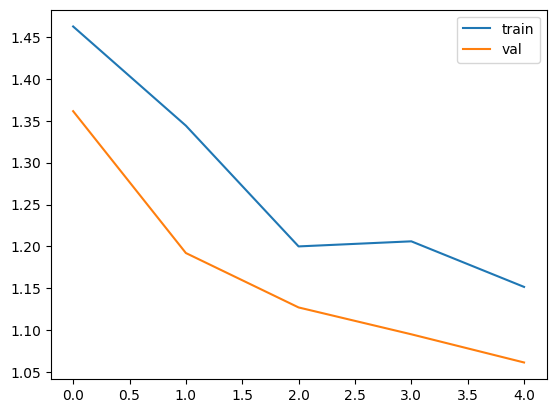

In [23]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.show()